Installing required packages

In [ ]:
!pip install facenet_pytorch pytorch_model_summary 

     |████████████████████████████████| 1.9MB 18.7MB/s 


Importing necessary packages

In [ ]:
import numpy as np
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from pylab import rcParams

import torch
import torchvision
import PIL

from torch import nn, optim
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader,SubsetRandomSampler
from torchvision import models,datasets
from torch.optim import lr_scheduler

from facenet_pytorch import InceptionResnetV1, fixed_image_standardization
from pytorch_model_summary import summary

import random

import cv2
import PIL.Image as Image

from google.colab.patches import cv2_imshow

from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict

Mounting the drive

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')
root_dir_path = os.path.join(os.getcwd(),'drive','MyDrive','Labelled Faces In The Wild Dataset')

Mounted at /content/drive


Dataset Paths

In [ ]:
original_dir_path = os.path.join(root_dir_path,'lfw-deepfunneled','lfw-deepfunneled')
original_cropped_dir_path = os.path.join(root_dir_path,'lfw-deepfunneled','lfw-deepfunneled_cropped')


surgical_masked_dir_path = os.path.join(root_dir_path,'lfw-deepfunneled','lfw-deepfunneled_masked_surgical')
surgical_masked_cropped_dir_path = os.path.join(root_dir_path,'lfw-deepfunneled','lfw-deepfunneled_masked_surgical_cropped')


KN95_masked_dir_path = os.path.join(root_dir_path,'lfw-deepfunneled','lfw-deepfunneled_masked_KN95')
KN95_masked_cropped_dir_path = os.path.join(root_dir_path,'lfw-deepfunneled','lfw-deepfunneled_masked_KN95_cropped')

Check for gpu availability

In [ ]:
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


Configuring some settings for visualization and seeding the values to makes the results as much reproducible as possible

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='darkgrid', palette='muted', font_scale=1.2)

colors_pallette = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(colors_pallette))

rcParams['figure.figsize'] = 16, 12

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Helper Functions for training , validation and visualizations

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  criterion, 
  optimizer, 
  device, 
  n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0

    print(f'Doing training on {n_examples} samples')

    for batch_idx , (b_images,b_labels) in enumerate(data_loader):

        if batch_idx%10 == 0:
            print(f' Processing batch {batch_idx+1}/{len(data_loader)} ')

        b_images = b_images.to(device)
        b_labels = b_labels.to(device)


        outputs = model(b_images)
        _, b_preds = torch.max(outputs, 1)
        
        loss = criterion(outputs,b_labels)

        correct_predictions += torch.sum(b_preds == b_labels)

        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    accuracy = correct_predictions.double() / n_examples
    loss = np.mean(losses)

    return accuracy , loss  

In [ ]:
def eval_model(
    model, 
    data_loader,
    criterion,
    device,
    n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    print(f'Doing validation on {n_examples} samples')

    with torch.no_grad():

        for batch_idx , (b_images,b_labels) in enumerate(data_loader):

            if batch_idx%10 == 0:
                print(f' Processing batch {batch_idx+1}/{len(data_loader)} ')

            b_images = b_images.to(device)
            b_labels = b_labels.to(device)


            outputs = model(b_images)
            _, b_preds = torch.max(outputs, 1)

            # print(b_preds.size())
            # print(b_labels.size())
            
            loss = criterion(outputs,b_labels)

            correct_predictions += torch.sum(b_preds == b_labels)

            losses.append(loss.item())
    
    accuracy = correct_predictions.double() / n_examples
    loss = round(np.mean(losses),2)

    return accuracy , loss  

In [ ]:
def train_model(
    model,
    train_data_loader,
    val_data_loader, 
    train_dataset_size,
    val_dataset_size,
    optimizer,
    criterion,
    scheduler,
    device, 
    n_epochs=3):

    history = defaultdict(list)

    best_accuracy = 0
    criterion.to(device)

    for epoch in range(n_epochs):

        print(f'Epoch {epoch + 1}/{n_epochs}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(
                                    model, 
                                    train_data_loader, 
                                    criterion, 
                                    optimizer, 
                                    device, 
                                    train_dataset_size
                                )

        print("Train loss {:.2f} accuracy {:.2f}".format(train_loss,train_acc))

        val_acc, val_loss = eval_model(
                                    model, 
                                    val_data_loader, 
                                    criterion, 
                                    device, 
                                    val_dataset_size

                            )

        print("Validation  loss {:.2f} accuracy {:.2f}".format(val_loss,val_acc))
        
        print()

        scheduler.step(val_loss)

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state.bin')
            best_accuracy = val_acc

    print(f'Best val accuracy: {best_accuracy}')

    model.load_state_dict(torch.load('best_model_state.bin'))

    return model, history

In [ ]:
def visualize_images(path,n_samples):
    '''
        path: expects list of paths to images or a single image's path
    '''
    cnt = 0
    for root,dirs,files in os.walk(path):
        for fname in files:
            if cnt == n_samples:
                return
            path = os.path.join(root,fname)
            img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
            cv2_imshow(img)
          
            cnt += 1

In [ ]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

In [ ]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

Visualize images from the directories

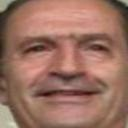

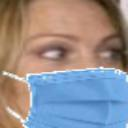

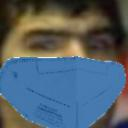

In [ ]:
visualize_images(path = original_cropped_dir_path,n_samples= 1)
visualize_images(path = surgical_masked_cropped_dir_path , n_samples= 1)
visualize_images(path = KN95_masked_cropped_dir_path , n_samples= 1)

In [ ]:
# dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((256, 256)))
# dataset.samples = [
#     (p, p.replace(data_dir, data_dir + '_cropped'))
#         for p, _ in dataset.samples
# ]
        
# loader = DataLoader(
#     dataset,
#     num_workers=workers,
#     batch_size=batch_size,
#     collate_fn=training.collate_pil
# )

# for i, (x, y) in enumerate(loader):
#     mtcnn(x, save_path=y)
#     print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')
    
# # Remove mtcnn to reduce GPU memory usage
# del mtcnn

Preparing the dataset and dataloaders

In [ ]:
batch_size = 64
validation_size = .2
test_size = 0.1
shuffle_dataset = True
data_dir = original_cropped_dir_path
num_workers = 0 if os.name == 'nt' else 8

transformations  = T.Compose([
    T.Resize(size = 256),
    T.ToTensor(),
    fixed_image_standardization
])

dataset = datasets.ImageFolder(data_dir, transform=transformations)


dataset_size = len(dataset)

indices = np.arange(dataset_size)

test_split = int(np.floor(test_size*dataset_size))

train_indices = indices[test_split:]
test_indices = indices[:test_split]


# Creating data indices for training and validation splits:
train_val_dataset_size = len(train_indices)
train_val_indices = list(range(train_val_dataset_size))

val_split = int(np.floor(validation_size * train_val_dataset_size))

if shuffle_dataset :
    np.random.seed(seed_val)
    np.random.shuffle(train_val_indices)

train_indices, val_indices = train_val_indices[val_split:], train_val_indices[:val_split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(
                                dataset, batch_size=batch_size, 
                                sampler=train_sampler,drop_last = True,
                                num_workers = num_workers
                )
validation_loader = torch.utils.data.DataLoader(
                                dataset, batch_size=batch_size,
                                sampler=valid_sampler,drop_last = True,
                                num_workers = num_workers
                    )

test_loader = torch.utils.data.DataLoader(
                                dataset, batch_size=batch_size,
                                sampler=valid_sampler,drop_last = True,
                                num_workers = num_workers
                    )

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print("Total number of different identies in the dataset {}".format(len(dataset.class_to_idx)))

Total number of different identies in the dataset 5749


In [ ]:
print("Total number of samples in the dataset {}".format(len(dataset.imgs)))

Total number of samples in the dataset 13233


Defining our model

In [ ]:
model = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(dataset.class_to_idx)
).to(device)

In [ ]:
print(model)

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

Keras type Model Summary

In [ ]:
print(summary(model, torch.zeros((1, 3, 256, 256)).to(device), show_input=True))

------------------------------------------------------------------------------
           Layer (type)           Input Shape         Param #     Tr. Param #
          BasicConv2d-1      [1, 3, 256, 256]             928             928
          BasicConv2d-2     [1, 32, 127, 127]           9,280           9,280
          BasicConv2d-3     [1, 32, 125, 125]          18,560          18,560
            MaxPool2d-4     [1, 64, 125, 125]               0               0
          BasicConv2d-5       [1, 64, 62, 62]           5,280           5,280
          BasicConv2d-6       [1, 80, 62, 62]         138,624         138,624
          BasicConv2d-7      [1, 192, 60, 60]         442,880         442,880
              Block35-8      [1, 256, 29, 29]          77,440          77,440
              Block35-9      [1, 256, 29, 29]          77,440          77,440
             Block35-10      [1, 256, 29, 29]          77,440          77,440
             Block35-11      [1, 256, 29, 29]          77,440  

Setting the optimizer,scheduler and loss criterion for the model training

In [ ]:
logits = model.logits.parameters()
optimizer = optim.Adam(logits, lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
criterion = nn.CrossEntropyLoss()

In [ ]:
model , history = train_model(
    model = model , train_data_loader = train_loader , val_data_loader = validation_loader,train_dataset_size = len(train_indices),
    val_dataset_size = len(val_indices) , optimizer = optimizer , criterion = criterion , scheduler = scheduler , 
    device = device , n_epochs = 50
)

Epoch 1/50
----------
Doing training on 9528 samples


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 Processing batch 1/148 
 Processing batch 11/148 
 Processing batch 21/148 
 Processing batch 31/148 
 Processing batch 41/148 
 Processing batch 51/148 
 Processing batch 61/148 
 Processing batch 71/148 
 Processing batch 81/148 
 Processing batch 91/148 
 Processing batch 101/148 
 Processing batch 111/148 
 Processing batch 121/148 
 Processing batch 131/148 
 Processing batch 141/148 
Train loss 7.03 accuracy 0.12
Doing validation on 2382 samples
 Processing batch 1/37 
 Processing batch 11/37 
 Processing batch 21/37 
 Processing batch 31/37 
Validation  loss 6.90 accuracy 0.17

Epoch 2/50
----------
Doing training on 9528 samples
 Processing batch 1/148 
 Processing batch 11/148 
 Processing batch 21/148 
 Processing batch 31/148 
 Processing batch 41/148 
 Processing batch 51/148 
 Processing batch 61/148 
 Processing batch 71/148 
 Processing batch 81/148 
 Processing batch 91/148 
 Processing batch 101/148 
 Processing batch 111/148 
 Processing batch 121/148 
 Processing ba

Saving the model 

In [ ]:
torch.save( model.state_dict() , os.path.join(root_dir_path ,"Models" ,"lfw_original_100.pth") )

In [ ]:
# writer = SummaryWriter()
# writer.iteration, writer.interval = 0, 10

# print('\n\nInitial')
# print('-' * 10)
# resnet.eval()
# training.pass_epoch(
#     resnet, loss_fn, val_loader,
#     batch_metrics=metrics, show_running=True, device=device,
#     writer=writer
# )

# for epoch in range(epochs):
#     print('\nEpoch {}/{}'.format(epoch + 1, epochs))
#     print('-' * 10)

#     resnet.train()
#     training.pass_epoch(
#         resnet, loss_fn, train_loader, optimizer, scheduler,
#         batch_metrics=metrics, show_running=True, device=device,
#         writer=writer
#     )

#     resnet.eval()
#     training.pass_epoch(
#         resnet, loss_fn, val_loader,
#         batch_metrics=metrics, show_running=True, device=device,
#         writer=writer
#     )

# writer.close()

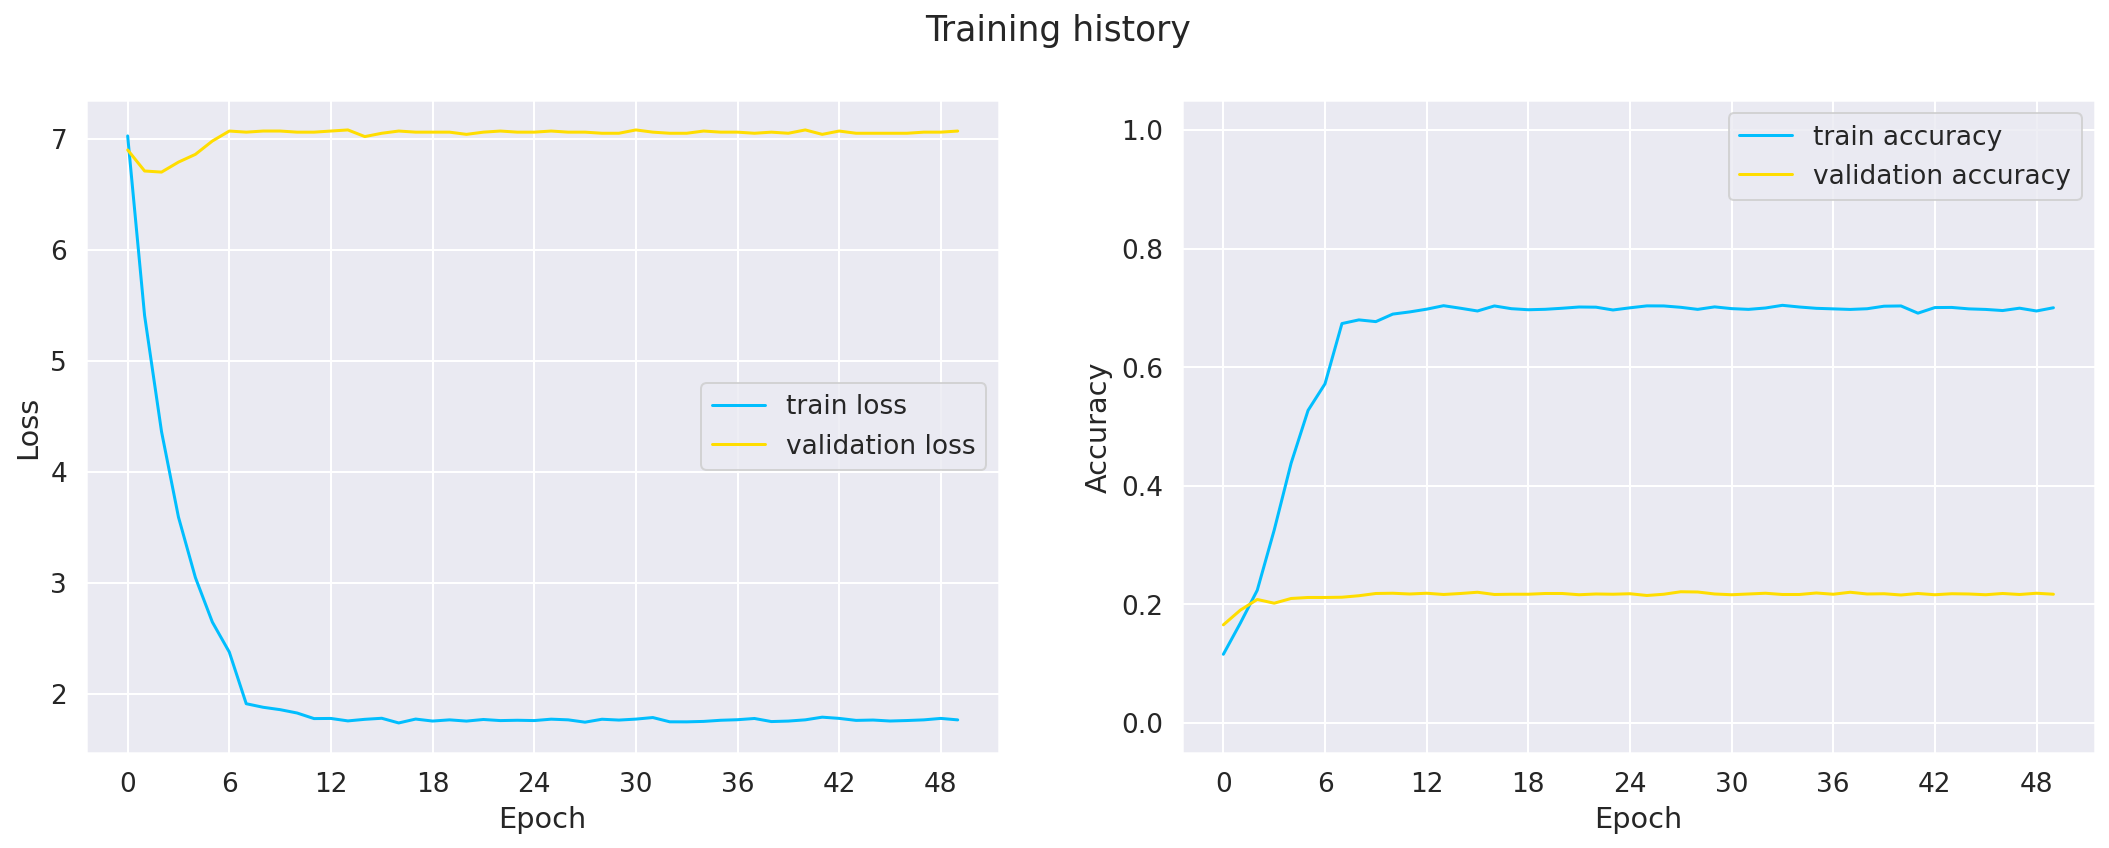

In [ ]:
plot_training_history(history)

In [ ]:
state_dict = torch.load(os.path.join(root_dir_path,'Models','lfw_original_vggface2_logits_50.pth'))
model.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

In [ ]:
print(eval_model(model = model , data_loader= train_loader , criterion=criterion,device=device , n_examples=len(train_indices)))

Doing validation on 9528 samples


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 Processing batch 1/148 
 Processing batch 11/148 
 Processing batch 21/148 
 Processing batch 31/148 
 Processing batch 41/148 
 Processing batch 51/148 
 Processing batch 61/148 
 Processing batch 71/148 
 Processing batch 81/148 
 Processing batch 91/148 
 Processing batch 101/148 
 Processing batch 111/148 
 Processing batch 121/148 
 Processing batch 131/148 
 Processing batch 141/148 
(tensor(0.8706, device='cuda:0', dtype=torch.float64), 1.04)


In [ ]:
print(eval_model(model = model , data_loader= validation_loader , criterion=criterion,device=device , n_examples=len(val_indices)))

Doing validation on 2382 samples


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 Processing batch 1/37 
 Processing batch 11/37 
 Processing batch 21/37 
 Processing batch 31/37 
(tensor(0.2212, device='cuda:0', dtype=torch.float64), 7.05)


In [ ]:
print(eval_model(model = model , data_loader= test_loader , criterion=criterion,device=device , n_examples=len(test_indices)))

Doing validation on 1323 samples


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 Processing batch 1/37 
 Processing batch 11/37 
 Processing batch 21/37 
 Processing batch 31/37 
(tensor(0.3968, device='cuda:0', dtype=torch.float64), 7.06)


In [ ]:
!nvidia-smi

Sun Apr  4 09:57:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    29W /  70W |  10080MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Sun Apr  4 09:57:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    29W /  70W |   2810MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
criterion = nn.CrossEntropyLoss()

In [ ]:
!nvidia-smi

Fri Apr  2 06:00:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    40W / 250W |  11181MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.empty_cache()

In [ ]:
torch.save( model.state_dict() , os.path.join(root_dir_path ,"Models" ,"lfw_original_50.pth") )

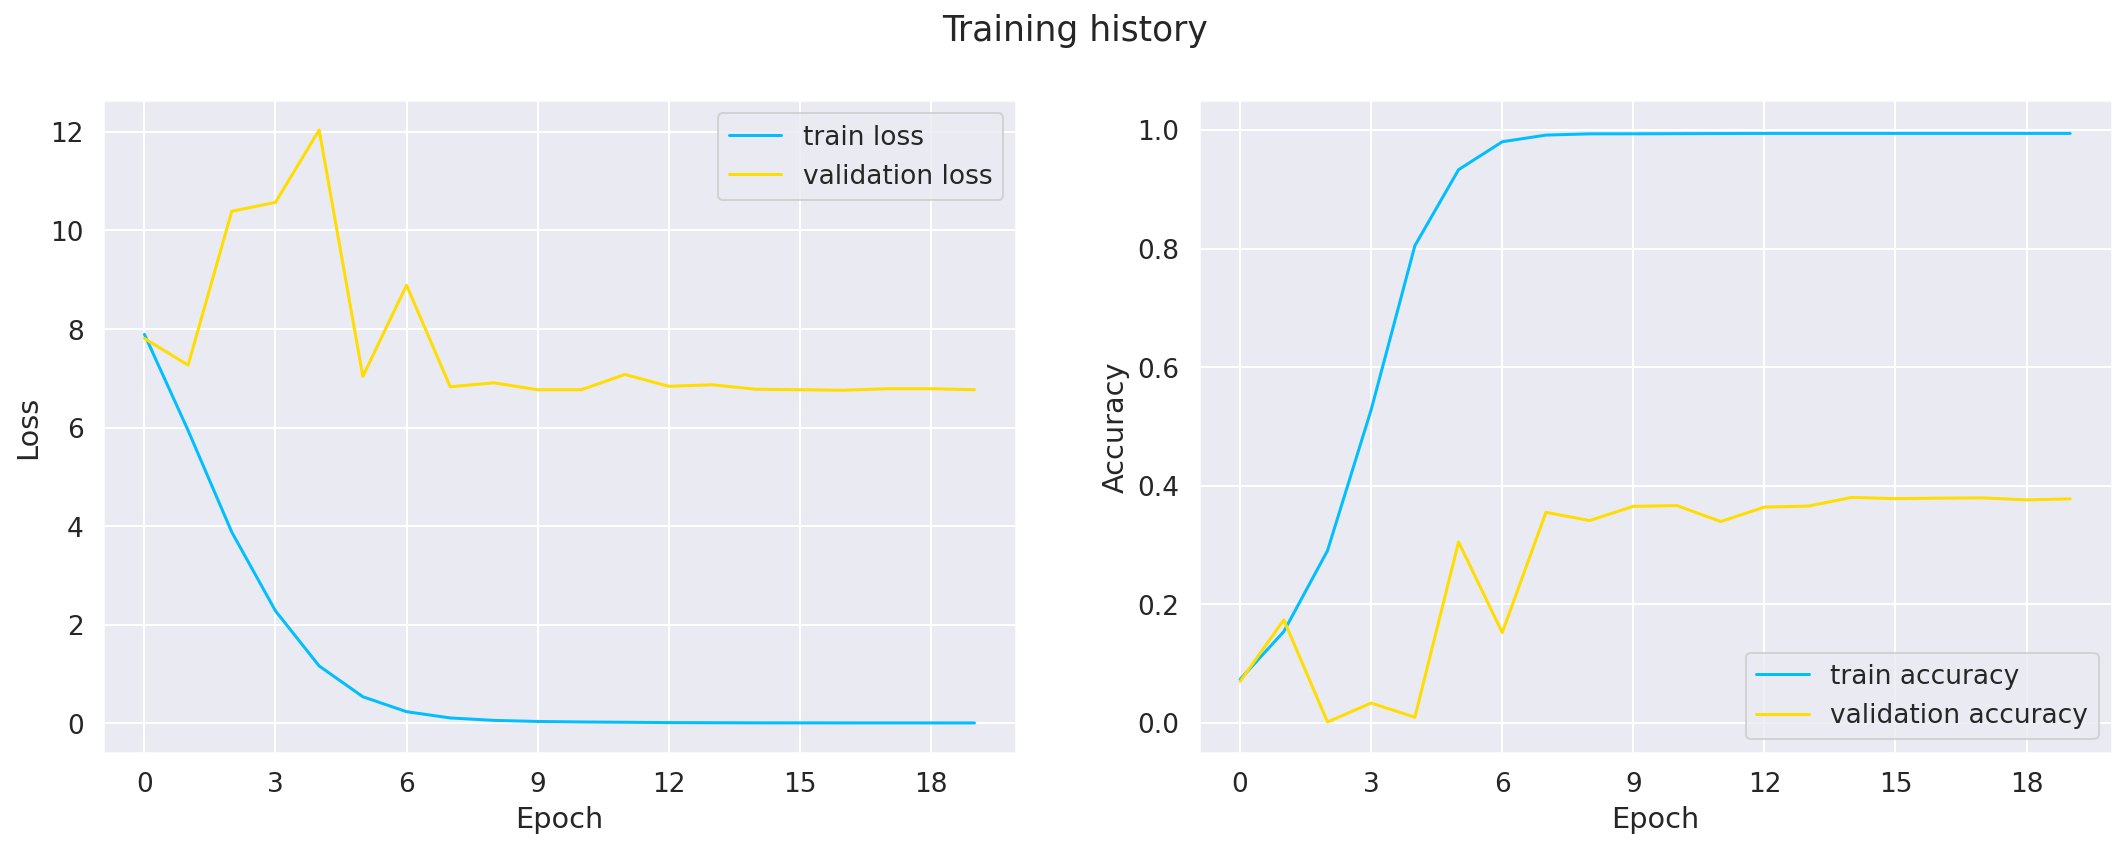

In [ ]:
plot_training_history(history)

In [ ]:
state_dict = torch.load(os.path.join(root_dir_path,'Models','lfw_original_vggface2_full_20.pth'))
model.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

In [ ]:
print(eval_model(model = model , data_loader= train_loader , criterion=criterion,device=device , n_examples=len(train_indices)))

Doing validation on 9528 samples


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 Processing batch 1/148 
 Processing batch 11/148 
 Processing batch 21/148 
 Processing batch 31/148 
 Processing batch 41/148 
 Processing batch 51/148 
 Processing batch 61/148 
 Processing batch 71/148 
 Processing batch 81/148 
 Processing batch 91/148 
 Processing batch 101/148 
 Processing batch 111/148 
 Processing batch 121/148 
 Processing batch 131/148 
 Processing batch 141/148 
(tensor(0.9941, device='cuda:0', dtype=torch.float64), 0.0)


In [ ]:
print(eval_model(model = model , data_loader= validation_loader , criterion=criterion,device=device , n_examples=len(val_indices)))

Doing validation on 2382 samples


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 Processing batch 1/37 
 Processing batch 11/37 
 Processing batch 21/37 
 Processing batch 31/37 
(tensor(0.3770, device='cuda:0', dtype=torch.float64), 6.81)


In [ ]:
print(eval_model(model = model , data_loader= test_loader , criterion=criterion,device=device , n_examples=len(test_indices)))

Doing validation on 1323 samples


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 Processing batch 1/37 
 Processing batch 11/37 
 Processing batch 21/37 
 Processing batch 31/37 
(tensor(0.6795, device='cuda:0', dtype=torch.float64), 6.81)


In [ ]:
model = InceptionResnetV1(
    classify=True,
    pretrained='casia-webface',
    num_classes=len(dataset.class_to_idx)
).to(device)

In [ ]:
optimizer = optim.Adam(model.logits.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
criterion = nn.CrossEntropyLoss()

In [ ]:
model , history = train_model(
    model = model , train_data_loader = train_loader , val_data_loader = validation_loader,train_dataset_size = len(train_indices),
    val_dataset_size = len(val_indices) , optimizer = optimizer , criterion = criterion , scheduler = scheduler , 
    device = device , n_epochs = 20
)

Epoch 1/20
----------
Doing training on 9528 samples


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 Processing batch 1/148 
 Processing batch 11/148 
 Processing batch 21/148 
 Processing batch 31/148 
 Processing batch 41/148 
 Processing batch 51/148 
 Processing batch 61/148 
 Processing batch 71/148 
 Processing batch 81/148 
 Processing batch 91/148 
 Processing batch 101/148 
 Processing batch 111/148 
 Processing batch 121/148 
 Processing batch 131/148 
 Processing batch 141/148 
Train loss 7.74 accuracy 0.11
Doing validation on 2382 samples
 Processing batch 1/37 
 Processing batch 11/37 
 Processing batch 21/37 
 Processing batch 31/37 
Validation  loss 6.88 accuracy 0.19

Epoch 2/20
----------
Doing training on 9528 samples
 Processing batch 1/148 
 Processing batch 11/148 
 Processing batch 21/148 
 Processing batch 31/148 
 Processing batch 41/148 
 Processing batch 51/148 
 Processing batch 61/148 
 Processing batch 71/148 
 Processing batch 81/148 
 Processing batch 91/148 
 Processing batch 101/148 
 Processing batch 111/148 
 Processing batch 121/148 
 Processing ba

In [ ]:
torch.save( model.state_dict() , os.path.join(root_dir_path ,"Models" ,"lfw_original_logits_casiawebface_20.pth") )

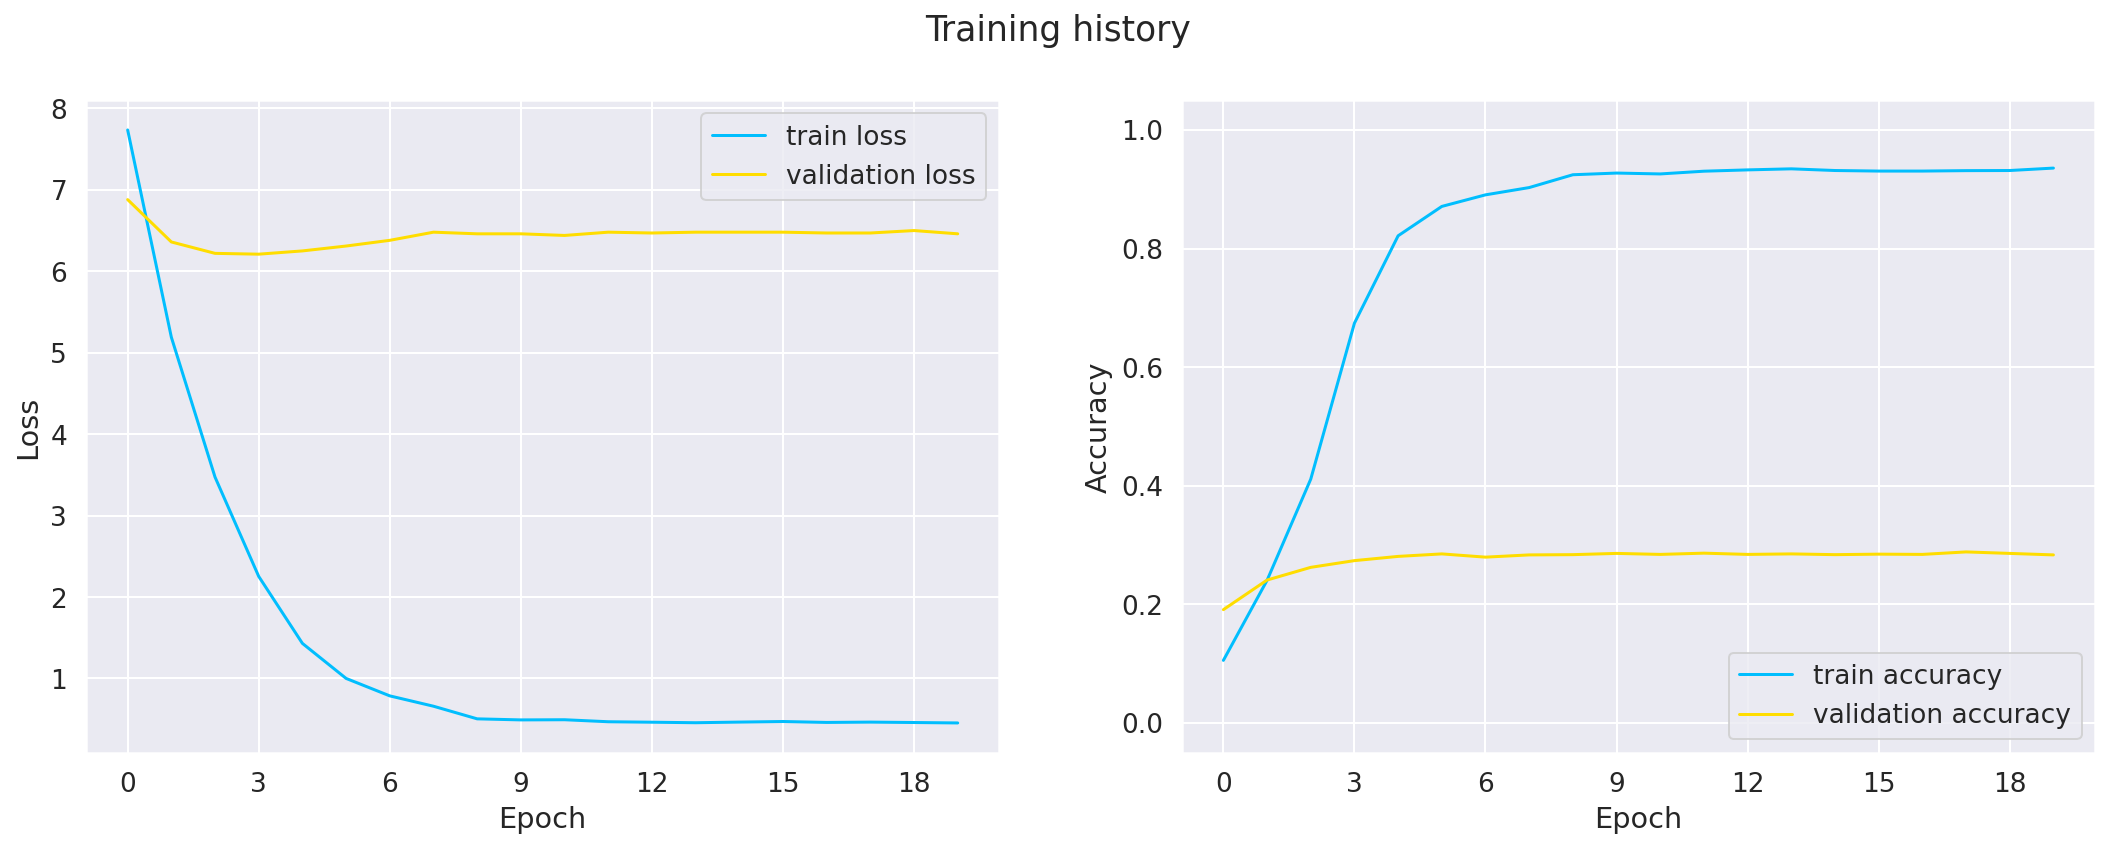

In [ ]:
plot_training_history(history)

In [ ]:
state_dict = torch.load(os.path.join(root_dir_path,'Models','lfw_original_logits_casiawebface_20.pth'))
model.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

In [ ]:
print(eval_model(model = model , data_loader=train_loader , criterion=criterion,device=device , n_examples=len(train_indices)))

Doing validation on 9528 samples


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 Processing batch 1/148 
 Processing batch 11/148 
 Processing batch 21/148 
 Processing batch 31/148 
 Processing batch 41/148 
 Processing batch 51/148 
 Processing batch 61/148 
 Processing batch 71/148 
 Processing batch 81/148 
 Processing batch 91/148 
 Processing batch 101/148 
 Processing batch 111/148 
 Processing batch 121/148 
 Processing batch 131/148 
 Processing batch 141/148 
(tensor(0.9724, device='cuda:0', dtype=torch.float64), 0.25)


In [ ]:
print(eval_model(model = model , data_loader= validation_loader , criterion=criterion,device=device , n_examples=len(val_indices)))

Doing validation on 2382 samples


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 Processing batch 1/37 
 Processing batch 11/37 
 Processing batch 21/37 
 Processing batch 31/37 
(tensor(0.2884, device='cuda:0', dtype=torch.float64), 6.47)


In [ ]:
print(eval_model(model = model , data_loader= test_loader , criterion=criterion,device=device , n_examples=len(test_indices)))

Doing validation on 1323 samples


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 Processing batch 1/37 
 Processing batch 11/37 
 Processing batch 21/37 
 Processing batch 31/37 
(tensor(0.5178, device='cuda:0', dtype=torch.float64), 6.49)


In [ ]:
torch.cuda.empty_cache()

In [ ]:
model = InceptionResnetV1(
    classify=True,
    pretrained='casia-webface',
    num_classes=len(dataset.class_to_idx)
).to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
criterion = nn.CrossEntropyLoss()

In [ ]:
model , history = train_model(
    model = model , train_data_loader = train_loader , val_data_loader = validation_loader,train_dataset_size = len(train_indices),
    val_dataset_size = len(val_indices) , optimizer = optimizer , criterion = criterion , scheduler = scheduler , 
    device = device , n_epochs = 20
)

Epoch 1/20
----------
Doing training on 9528 samples


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 Processing batch 1/148 
 Processing batch 11/148 
 Processing batch 21/148 
 Processing batch 31/148 
 Processing batch 41/148 
 Processing batch 51/148 
 Processing batch 61/148 
 Processing batch 71/148 
 Processing batch 81/148 
 Processing batch 91/148 
 Processing batch 101/148 
 Processing batch 111/148 
 Processing batch 121/148 
 Processing batch 131/148 
 Processing batch 141/148 
Train loss 7.62 accuracy 0.09
Doing validation on 2382 samples
 Processing batch 1/37 
 Processing batch 11/37 
 Processing batch 21/37 
 Processing batch 31/37 
Validation  loss 48.23 accuracy 0.00

Epoch 2/20
----------
Doing training on 9528 samples
 Processing batch 1/148 
 Processing batch 11/148 
 Processing batch 21/148 
 Processing batch 31/148 
 Processing batch 41/148 
 Processing batch 51/148 
 Processing batch 61/148 
 Processing batch 71/148 
 Processing batch 81/148 
 Processing batch 91/148 
 Processing batch 101/148 
 Processing batch 111/148 
 Processing batch 121/148 
 Processing b

In [ ]:
torch.save( model.state_dict() , os.path.join(root_dir_path ,"Models" ,"lfw_original_full_casiawebface_20.pth") )

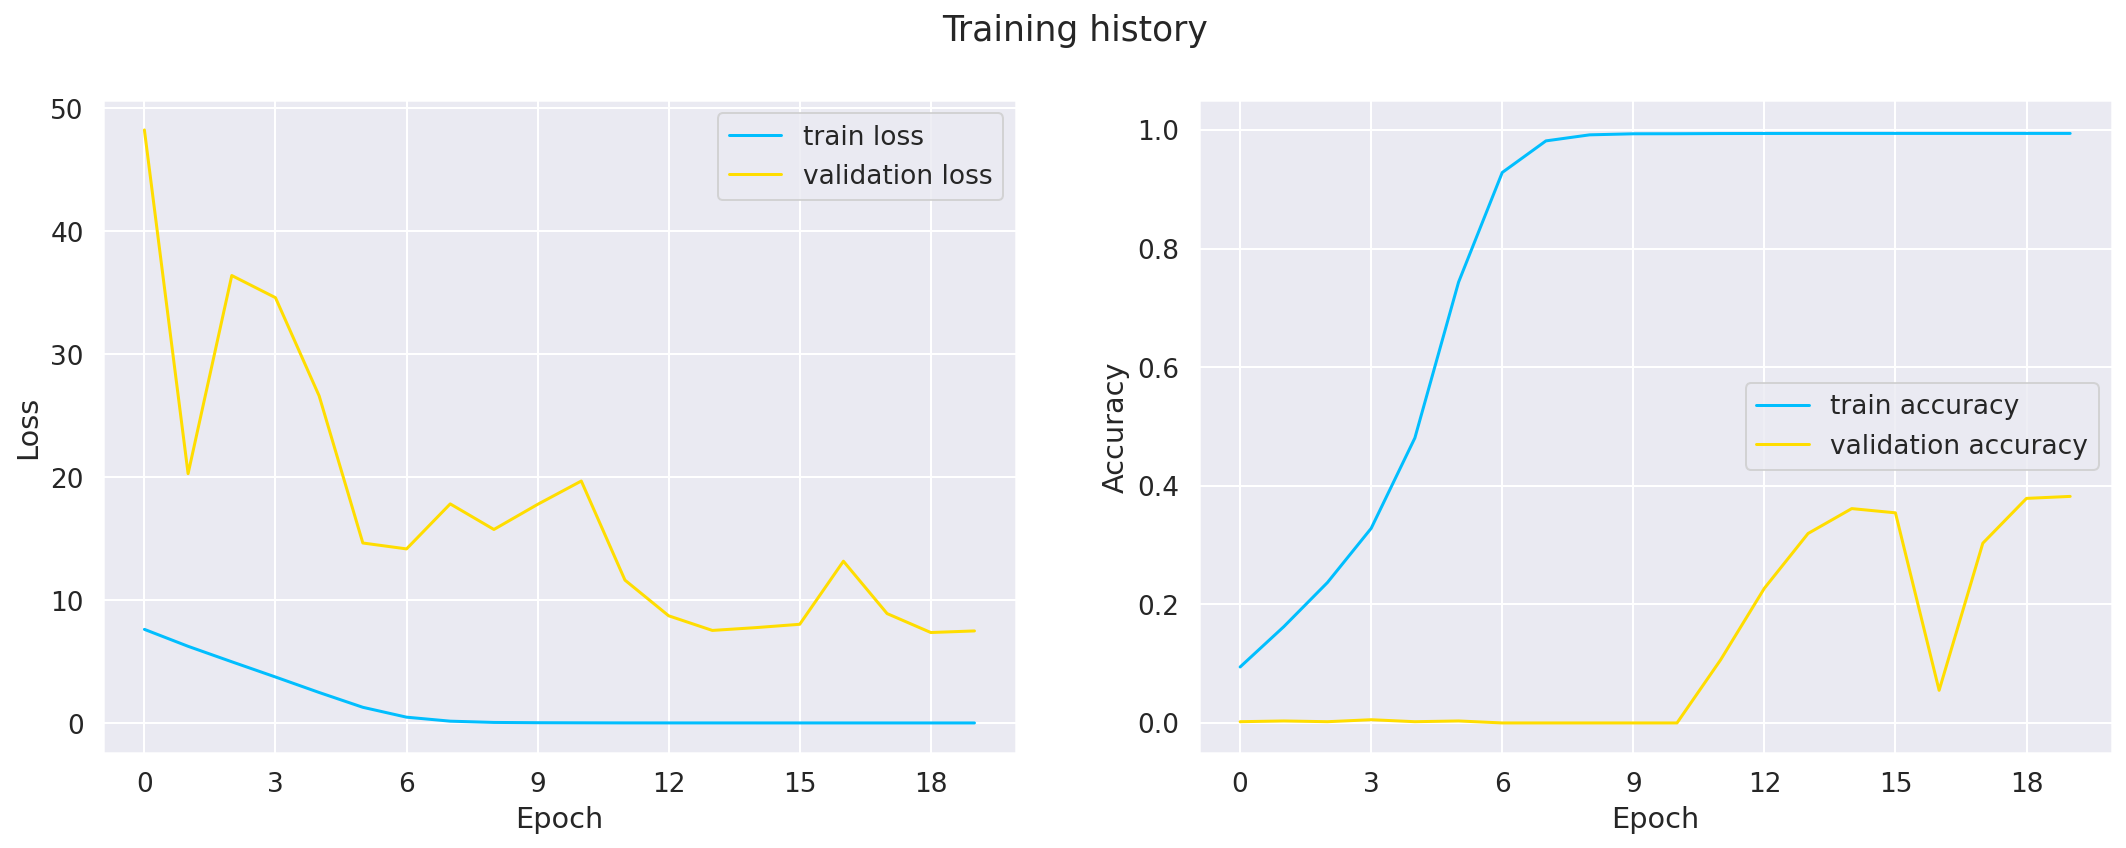

In [ ]:
plot_training_history(history)

In [ ]:
state_dict = torch.load(os.path.join(root_dir_path,'Models','lfw_original_full_casiawebface_20.pth'))
model.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

In [ ]:
print(eval_model(model = model , data_loader=train_loader , criterion=criterion,device=device , n_examples=len(train_indices)))

Doing validation on 9528 samples


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 Processing batch 1/148 
 Processing batch 11/148 
 Processing batch 21/148 
 Processing batch 31/148 
 Processing batch 41/148 
 Processing batch 51/148 
 Processing batch 61/148 
 Processing batch 71/148 
 Processing batch 81/148 
 Processing batch 91/148 
 Processing batch 101/148 
 Processing batch 111/148 
 Processing batch 121/148 
 Processing batch 131/148 
 Processing batch 141/148 
(tensor(0.9941, device='cuda:0', dtype=torch.float64), 0.0)


In [ ]:
print(eval_model(model = model , data_loader=validation_loader , criterion=criterion,device=device , n_examples=len(val_indices)))

Doing validation on 2382 samples


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 Processing batch 1/37 
 Processing batch 11/37 
 Processing batch 21/37 
 Processing batch 31/37 
(tensor(0.3808, device='cuda:0', dtype=torch.float64), 7.51)


In [ ]:
print(eval_model(model = model , data_loader= test_loader , criterion=criterion,device=device , n_examples=len(test_indices)))

Doing validation on 1323 samples


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 Processing batch 1/37 
 Processing batch 11/37 
 Processing batch 21/37 
 Processing batch 31/37 
(tensor(0.6863, device='cuda:0', dtype=torch.float64), 7.5)
